In [365]:
import pandas as pd
import seaborn as sns
import numpy as np
import plotly.express as px
import re

In [282]:
ads_data = pd.read_csv('C:/Users/bkunt/jupyter/karpov/data/ads/ads_data.csv', parse_dates=[0, 1])

In [283]:
ads_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269
1,2019-04-01,2019-04-01 00:00:48,view,web,121288,121288,121288,CPM,187.4,0,232011
2,2019-04-01,2019-04-01 00:01:03,view,android,102737,102535,102564,CPC,60.7,0,4410
3,2019-04-01,2019-04-01 00:01:03,view,android,107564,106914,107564,CPM,217.3,0,62711
4,2019-04-01,2019-04-01 00:01:09,view,android,4922,37,4400,CPC,60.1,0,1183501


In [284]:
ads_data.shape

(1000000, 11)

In [285]:
ads_data.dtypes

date                     datetime64[ns]
time                     datetime64[ns]
event                            object
platform                         object
ad_id                             int64
client_union_id                   int64
campaign_union_id                 int64
ad_cost_type                     object
ad_cost                         float64
has_video                         int64
target_audience_count             int64
dtype: object

In [286]:
ads_data.nunique()

date                         6
time                     25209
event                        2
platform                     3
ad_id                      965
client_union_id            838
campaign_union_id          909
ad_cost_type                 2
ad_cost                    451
has_video                    2
target_audience_count      953
dtype: int64

In [287]:
ads_data.isna().sum()

date                     0
time                     0
event                    0
platform                 0
ad_id                    0
client_union_id          0
campaign_union_id        0
ad_cost_type             0
ad_cost                  0
has_video                0
target_audience_count    0
dtype: int64

In [288]:
#посчитаем среднее количество разных рекламных событий (просмотры и клики) по объявлениям
ads_data.groupby(['ad_id', 'event'], as_index=False) \
        .agg({'platform': 'count'}) \
        .rename(columns={'platform': 'overall'}) \
        .pivot(index='ad_id', columns='event', values='overall').fillna(0).mean().round(0)

event
click    113.0
view     923.0
dtype: float64

In [289]:
#посчитаем то же самое более простым способом
ads_data.groupby('event') \
        .agg({'platform': 'count'}) \
        .rename(columns={'platform': 'overall'}).div(965).round(0)

,overall
event,
click,113.0
view,923.0


In [290]:
#посмотрим на количество просмотров по объявлениям
views_per_ad = ads_data.query('event == "view"') \
                       .groupby('ad_id', as_index=False) \
                       .agg({'platform': 'count'}) \
                       .rename(columns={'platform': 'views'})

C:\Users\bkunt\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='views', ylabel='Density'>

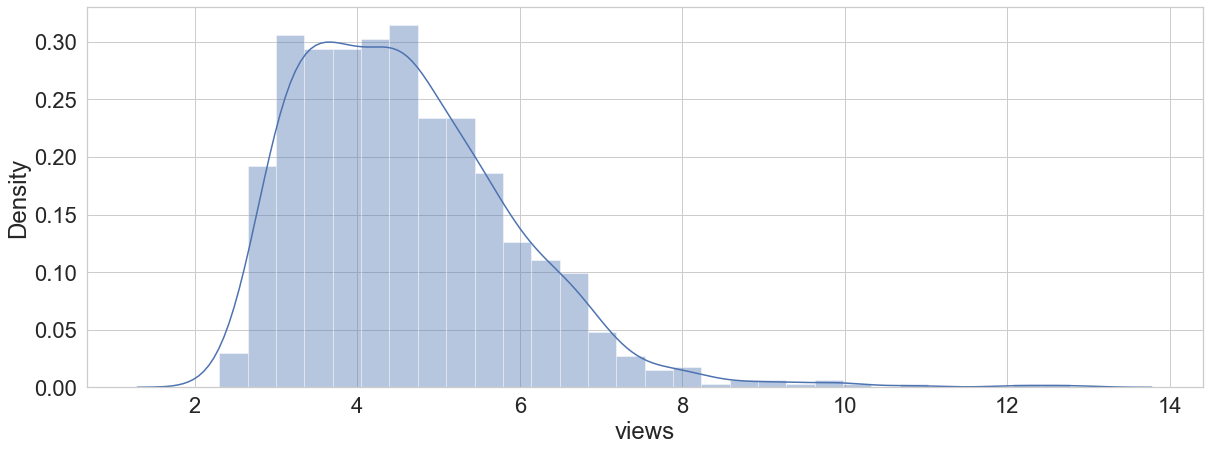

In [291]:
#построим график распределения количества просмотров объявлений
sns.set(font_scale=2, style="whitegrid", rc={'figure.figsize':(20,7)})
sns.distplot(np.log(views_per_ad.views))

In [292]:
#посчитаем количество просмотров на объявление по датам
ads_views_per_date = ads_data.query('event == "view"') \
                             .groupby(['ad_id', 'date'], as_index=False) \
                             .agg({'platform': 'count'}) \
                             .rename(columns={'platform': 'views'})

In [293]:
ads_views_per_date.head()

,ad_id,date,views
0,2,2019-04-01,83
1,2,2019-04-02,18
2,3,2019-04-01,158
3,3,2019-04-02,26
4,1902,2019-04-03,34


In [294]:
#найдем среднее количество просмотров на 1 объявление
mean_ads_views_per_date = ads_views_per_date.groupby('date') \
                                            .agg({'views': 'mean'})

In [295]:
#вычислим значения скользящего среднего по дням
rolling_ads_views_per_date = mean_ads_views_per_date.rolling(2).mean().round(0)

<AxesSubplot:xlabel='date', ylabel='views'>

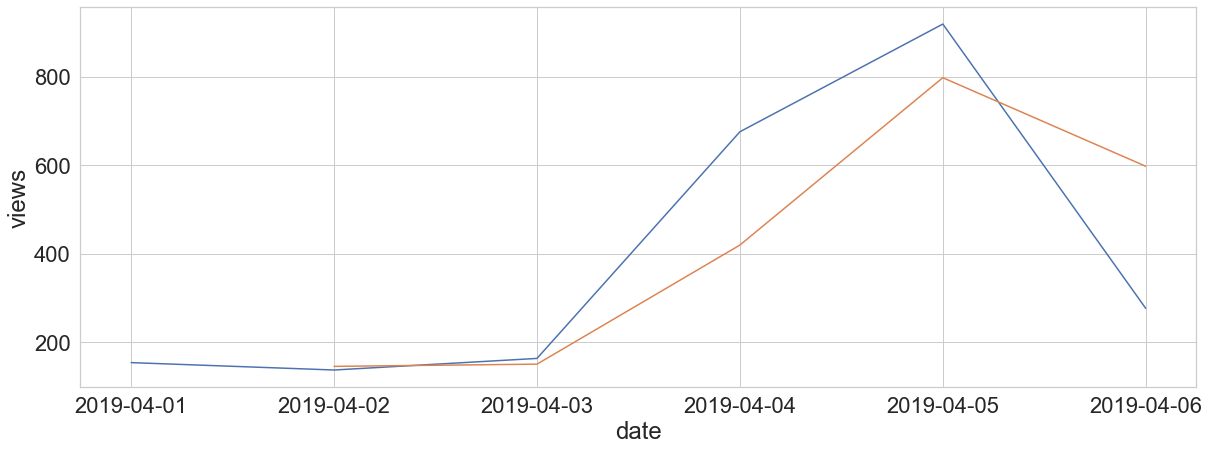

In [296]:
#нанесем получившиеся данные на график
sns.lineplot(x=mean_ads_views_per_date.index, y=mean_ads_views_per_date.views)
sns.lineplot(x=rolling_ads_views_per_date.index, y=rolling_ads_views_per_date.views)

In [297]:
#вычислим, в какой день разница по модулю между двумя показателями наибольшая
np.absolute(rolling_ads_views_per_date.views - mean_ads_views_per_date.views).idxmax()

Timestamp('2019-04-06 00:00:00')

In [298]:
#добавим новые данные
ads_clients = pd.read_csv('C:/Users/bkunt/jupyter/karpov/data/ads/ads_clients_data.csv', parse_dates=['date', 'create_date'])

In [299]:
ads_clients.head()

,date,client_union_id,community_id,create_date
0,2020-05-07,1,-130371893,2018-12-24
1,2020-05-07,2,-130304626,2019-02-10
2,2020-05-07,3,-130462599,2019-01-25
3,2020-05-07,4,-130574300,2018-12-09
4,2020-05-07,5,-130292358,2019-01-08


In [300]:
ads_clients.shape

(122078, 4)

In [301]:
#удалим ненужные столбцы
ads_clients.drop(columns=['date', 'community_id'], inplace=True)

In [302]:
ads_clients.nunique()

client_union_id    122078
create_date           222
dtype: int64

In [303]:
ads_clients.dtypes

client_union_id             int64
create_date        datetime64[ns]
dtype: object

In [304]:
ads_clients.isna().sum()

client_union_id    0
create_date        0
dtype: int64

In [305]:
#объединим два датафрейма
full_data = ads_data.merge(ads_clients)

In [306]:
full_data.head()

,date,time,event,platform,ad_id,client_union_id,campaign_union_id,ad_cost_type,ad_cost,has_video,target_audience_count,create_date
0,2019-04-01,2019-04-01 00:00:48,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
1,2019-04-01,2019-04-01 00:03:28,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
2,2019-04-01,2019-04-01 00:04:58,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
3,2019-04-01,2019-04-01 00:10:23,view,ios,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04
4,2019-04-01,2019-04-01 00:15:42,view,android,45061,34734,45061,CPM,200.6,0,1955269,2018-12-04


In [307]:
#создадим колонку, в которой указано количество дней между регистрацией клиента и его первым запуском рекламы
full_data['delay'] = full_data.date - full_data.create_date

In [308]:
#высчитаем среднее количество дней
full_data.groupby('client_union_id', as_index=False) \
         .agg({'delay': 'min'}).delay.mean()

Timedelta('124 days 09:04:43.532219570')

In [309]:
full_data['more_than_year'] = pd.to_timedelta(365, unit='day') < pd.to_timedelta(full_data.delay, unit='day')

In [320]:
#посчитаем конверсию из создания рекламного кабинета в запуск первой рекламы
clients_conversion = full_data.client_union_id.nunique() / ads_clients.client_union_id.nunique() * 100
round(clients_conversion, 2)

0.69

In [333]:
#разобъем клиентов на категории в зависимости от быстроты конверсии
periods = [0, 30, 90, 180, 365]
timedelta_periods = []
for period in periods:
    timedelta_periods.append(pd.to_timedelta(period, unit='day'))
    
labels = ['less than 1 month', '1-3 months', '3-6 months', '6-12 months']    
full_data['category'] = pd.cut(full_data.delay, bins=timedelta_periods, labels=labels)

In [345]:
#определим количество уникальных клиентов по категориям
unique_clients = full_data.groupby('category', as_index=False) \
                          .agg({'client_union_id': 'nunique'}) \
                          .rename(columns={'client_union_id': 'clients'})

In [356]:
#построим интерактивный график по получившимся категориям
px.bar(x=unique_clients.category, y=unique_clients.clients)

In [360]:
#загрузим данные по дополнительному проекту
flys_genome = pd.read_csv('C:/Users/bkunt/jupyter/karpov/data/gff.tsv', sep='\t')

In [362]:
flys_genome.head()

,seq_id,source,type,start,end,score,strand,phase,attributes
0,chr17,RefSeq,exon,6811330,6811453,.,+,.,Parent=XM_001475631.1
1,chr17,RefSeq,CDS,6808204,6808245,.,+,0,Name=CDS:NC_000083.5:LOC100040603;Parent=XM_00...
2,chr17,RefSeq,CDS,6811792,6811869,.,+,2,Name=CDS:NC_000083.5:LOC100040603;Parent=XM_00...
3,chr17,RefSeq,exon,6806513,6806553,.,+,.,Parent=XM_001475631.1
4,chr17,RefSeq,five_prime_UTR,6806513,6806526,.,+,.,Parent=XM_001475631.1


In [363]:
flys_genome.shape

(512, 9)

In [364]:
flys_genome.dtypes

seq_id        object
source        object
type          object
start          int64
end            int64
score         object
strand        object
phase         object
attributes    object
dtype: object

In [375]:
#создадим шаблон, по которому необходим поиск
pattern = re.compile('Parent=([\w.]+)')

In [409]:
#запишем найденные совпадения в новую колонку
flys_genome['parent'] = flys_genome.attributes.str.findall(pattern)

In [414]:
#самое частое значение в новой колонке
flys_genome.parent.value_counts()

[XM_001475631.1]    479
[NC_000083.5]        33
Name: parent, dtype: int64

In [413]:
#самое частое значение в колонке type
flys_genome.type.value_counts()

exon               201
CDS                170
five_prime_UTR      47
mRNA                33
three_prime_UTR     32
protein             29
Name: type, dtype: int64